# Run-up

In [ ]:
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

In [1]:
import os
import json
from os import listdir
from os.path import isfile, join
import nibabel as nib
import numpy as np
from tqdm.notebook import tqdm
import torchvision
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import albumentations as A
import segmentation_models_pytorch as smp
from torchvision import models
from IPython.display import clear_output
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
CORE_PATH = "./drive/MyDrive/Colab Notebooks/Tinkoff/DL/tgcovid/"
CHECKPOINTS_PATH = CORE_PATH + "/checkpoints/"
DATA_PATH = CORE_PATH + "/data/"

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

device = torch.device(device)
print(device)

cpu


# Data preparation

In [ ]:
class CovidDataset(Dataset):
    def __init__(self, data_path, names_path, X_data, without_covid_max=1000):
        path_images = os.path.join(data_path, 'images')
        path_labels = os.path.join(data_path, 'labels')
        
        with open(names_path + 'training_data.json', 'r') as f:
            dict_training = json.load(f)

        self.X = []
        self.Y = []
        without_covid = 0

        for entry in tqdm(dict_training):
            image = nib.load(os.path.join(path_images, entry['image'][:-3]))
            label = nib.load(os.path.join(path_labels, entry['label'][:-3]))

            image = torch.tensor(image.get_fdata()).transpose(1, 2).transpose(0, 1)
            label = torch.tensor(label.get_fdata()).transpose(1, 2).transpose(0, 1)
            
            if entry['image'][:-3] in X_data: # Если этот кт-скан в трейне - загружаем его туда
                for i in range(len(image)): # Пробегаемся по всем слоям в нужном кт-скане image
                    if label[i].sum() == 0:
                        if without_covid > without_covid_max:
                            continue
                        else:
                            without_covid += 1

                    self.X.append(image[i]) # Добавляем отдельные картинки
                    self.Y.append(label[i])

                    
    def __len__(self):
        return len(self.X)
    
    
    def __getitem__(self, idx):
        degrees = list(range(-35, 36, 5))

        X, y = torch.Tensor(self.X[idx].float()), torch.Tensor(self.Y[idx].float())
        X, y = X.unsqueeze(0), y.unsqueeze(0)

        if random.random() > 0.5:
            if random.random() > 0.5:
                X = torchvision.transforms.functional.vflip(X)
                y = torchvision.transforms.functional.vflip(y)
            else:
                X = torchvision.transforms.functional.hflip(X)
                y = torchvision.transforms.functional.hflip(y)

        if random.random() > 0.2:
            degree = random.choice(degrees)
            X = torchvision.transforms.functional.rotate(X, degree)
            y = torchvision.transforms.functional.rotate(y, degree)

        if random.random() > 0.8:
            X = torchvision.transforms.RandomPerspective(distortion_scale=0.15, p=0.5, interpolation=2, fill=0)(X)
            y = torchvision.transforms.RandomPerspective(distortion_scale=0.15, p=0.5, interpolation=2, fill=0)(y)

        if random.random() > 0.8:
            X = torchvision.transforms.GaussianBlur(1)(X)
            y = torchvision.transforms.GaussianBlur(1)(y)

        return X, y

In [ ]:
file_names = [f for f in listdir(DATA_PATH + "images") if isfile(join(DATA_PATH + "images", f))]
file_names[:5]

['study_0255.nii',
 'study_0256.nii',
 'study_0258.nii',
 'study_0257.nii',
 'study_0259.nii']

In [ ]:
# np.random.shuffle(file_names)

file_names_train = ['study_0265.nii', 'study_0294.nii', 'study_0302.nii', 'study_0268.nii', 'study_0266.nii',
                    'study_0260.nii', 'study_0285.nii', 'study_0284.nii', 'study_0304.nii', 'study_0287.nii',
                    'study_0269.nii', 'study_0276.nii', 'study_0297.nii', 'study_0262.nii', 'study_0279.nii',
                    'study_0270.nii', 'study_0278.nii', 'study_0267.nii', 'study_0292.nii', 'study_0272.nii',
                    'study_0293.nii', 'study_0274.nii', 'study_0275.nii', 'study_0286.nii', 'study_0295.nii',
                    'study_0280.nii', 'study_0258.nii', 'study_0263.nii', 'study_0288.nii', 'study_0255.nii',
                    'study_0291.nii', 'study_0256.nii', 'study_0282.nii', 'study_0273.nii', 'study_0259.nii']

file_names_test = ['study_0296.nii', 'study_0271.nii', 'study_0283.nii', 'study_0290.nii', 'study_0277.nii',
                   'study_0257.nii', 'study_0301.nii', 'study_0299.nii', 'study_0261.nii', 'study_0300.nii',
                   'study_0289.nii', 'study_0303.nii', 'study_0298.nii', 'study_0264.nii', 'study_0281.nii']

In [ ]:
batch_size = 8

train_dataset = CovidDataset(DATA_PATH, CORE_PATH, file_names_train, 50)
valid_dataset = CovidDataset(DATA_PATH, CORE_PATH, file_names_test, 50)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
len(train_dataset), len(valid_dataset)

(494, 223)

## Visualize some of the slices

In [ ]:
def blend(image, mask, detach=True):
    if detach:
        image = image.detach().cpu().numpy().astype(np.float32)
        mask = mask.detach().cpu().numpy()

    min_in, max_in = image.min(), image.max()
    image = (image - min_in) / (max_in - min_in + 1e-8) * 255
    image = np.dstack((image, image, image)).astype(np.uint8)

    zeros = np.zeros_like(mask)
    mask = np.dstack((zeros, zeros, mask * 255)).astype(np.uint8)

    return Image.blend(
        Image.fromarray(image),
        Image.fromarray(mask),
        alpha=.2
    )

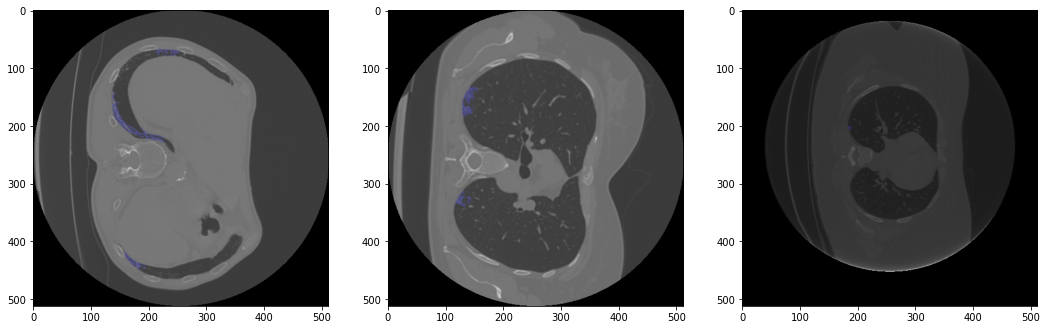

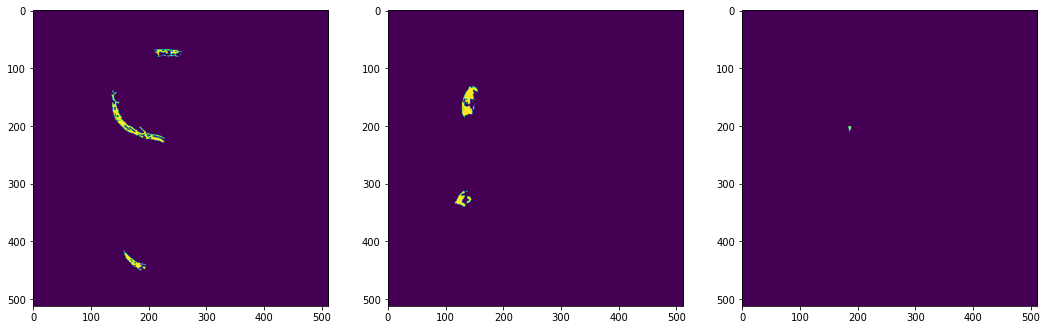

In [ ]:
slices_nums = [100, 200, 300]
slices = [blend(train_dataset.X[idx], train_dataset.Y[idx]) for idx in slices_nums]

figure = plt.figure(figsize=(18, 18))
for i, image in enumerate(slices):
    ax = figure.add_subplot(1, len(slices), i + 1)
    ax.imshow(slices[i])

figure = plt.figure(figsize=(18, 18))
for i, idx in enumerate(slices_nums):
    ax = figure.add_subplot(1, len(slices), i + 1)
    ax.imshow(train_dataset.Y[idx])

# SegNet and UNet implementation

## SegNet

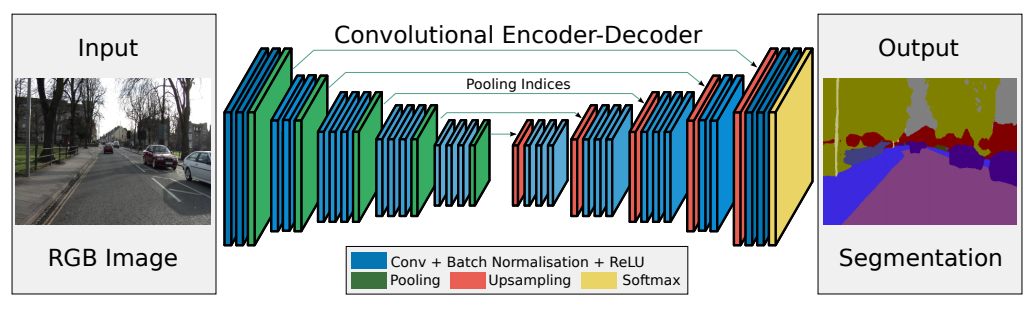

In [ ]:
class SegNet(nn.Module):
    def _block(self, in_features, out_features):
        return nn.Sequential(
            nn.Conv2d(in_features, out_features, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(out_features, eps=1e-05, momentum=0.1),
            nn.ReLU(),
        )

    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            self._block(in_channels, 64),
            self._block(64, 64),
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv1 = nn.Sequential(
            self._block(64, 128),
            self._block(128, 128),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv2 = nn.Sequential(
            self._block(128, 256),
            self._block(256, 256),
            self._block(256, 256),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv3 = nn.Sequential(
            self._block(256, 512),
            self._block(512, 512),
            self._block(512, 512),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(
            self._block(512, 512),
            self._block(512, 512),
            self._block(512, 256),
        )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(
            self._block(256, 256),
            self._block(256, 256),
            self._block(256, 128),
        )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(
            self._block(128, 128),
            self._block(128, 64),
        )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv3 = nn.Sequential(
            self._block(64, 64),
            nn.Conv2d(64, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, ind3))
        d1 = self.dec_conv1(self.upsample1(d0, ind2))
        d2 = self.dec_conv2(self.upsample2(d1, ind1))
        d3 = self.dec_conv3(self.upsample3(d2, ind0))

        return nn.Sigmoid()(d3)

## U-Net

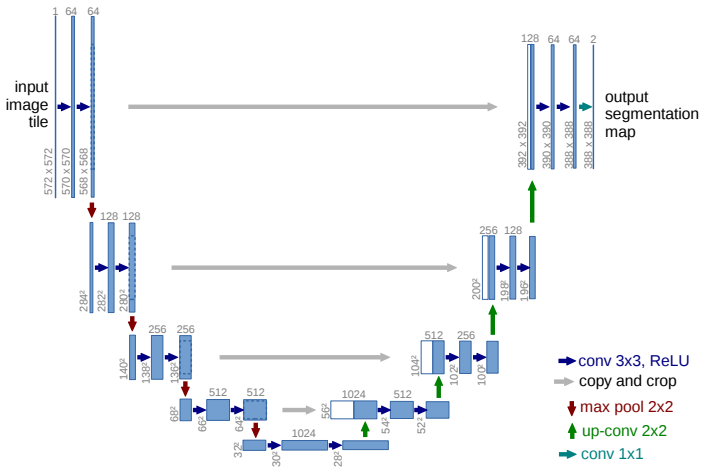

In [ ]:
class UNet(nn.Module):
    def _block(self, in_features, out_features):
        return nn.Sequential(
            nn.Conv2d(in_features, out_features, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(out_features, eps=1e-05, momentum=0.1),
            nn.ReLU(),
        )

    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            self._block(in_channels, 64),
            self._block(64, 64),
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv1 = nn.Sequential(
            self._block(64, 128),
            self._block(128, 128),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = nn.Sequential(
            self._block(128, 256),
            self._block(256, 256),
            self._block(256, 256),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv3 = nn.Sequential(
            self._block(256, 512),
            self._block(512, 512),
            self._block(512, 512),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            self._block(512, 1024),
            self._block(1024, 1024),
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(
            self._block(1024, 1024),
            self._block(1024, 512),
            self._block(512, 512),
        )
        self.upsample1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(
            self._block(512, 512),
            self._block(512, 256),
            self._block(256, 256),
        )
        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(
            self._block(256, 256),
            self._block(256, 128),
        )
        self.upsample3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Sequential(
            self._block(128, 64),
            self._block(64, 64),
            nn.Conv2d(64, out_channels, kernel_size=(1, 1), stride=(1, 1))
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        d0 = self.dec_conv0(torch.cat([e3, self.upsample0(b)], dim=1))
        d1 = self.dec_conv1(torch.cat([e2, self.upsample1(d0)], dim=1))
        d2 = self.dec_conv2(torch.cat([e1, self.upsample2(d1)], dim=1))
        d3 = self.dec_conv3(torch.cat([e0, self.upsample3(d2)], dim=1))
        
        return nn.Sigmoid()(d3)

# Metrics implementation

In [ ]:
def iou_metric(labels: torch.Tensor, outputs: torch.Tensor):
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    smooth = 1e-8

    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))
    iou = (intersection + smooth) / (union + smooth)
    
    return iou


def dice_metric(labels: torch.Tensor, outputs: torch.Tensor):
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    smooth = 1e-8

    intersection = (outputs & labels).float().sum((1, 2))
    outputs_sum = outputs.float().sum((1, 2))
    labels_sum = labels.float().sum((1, 2))
    dice = (intersection + smooth) / (outputs_sum + labels_sum + smooth)
    
    return dice

# Loss functions implementation

In [ ]:
def bce_loss(y_true, y_pred):
    return (torch.log(1 + torch.exp(y_pred)) - y_pred * y_true).mean()


def dice_loss(y_true, y_pred, smooth=1e-5):
    num = 2 * torch.sum(y_pred * y_true) + smooth
    den = torch.sum(y_pred) + torch.sum(y_true) + smooth

    return 1 - num / den


def focal_loss(y_true, y_pred, gamma=2):
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)

    loss = -((1-y_pred)**gamma * y_true * y_pred.log() + (1 - y_true)*(1 - y_pred).log())

    return loss.mean()


def focal_tversky_loss(y_true, y_pred, alpha=0.7, gamma=0.75, smooth=1):
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)

    TP = torch.sum(y_true * y_pred)
    FN = torch.sum(y_true * (1 - y_pred))
    FP = torch.sum((1 - y_true) * y_pred)

    tversky_loss = 1 - (TP + smooth) / (TP + alpha * FN + (1 - alpha) * FP + smooth)

    return torch.pow((tversky_loss), gamma)

# Training tools

In [ ]:
def train(model, opt, lr_sched, loss_fn, num_epochs, data_tr, data_val, metrics,
          save_path, history=[], curr_epoch=0, threshold=0.9):
    
    X_val, Y_val = next(iter(data_val)) # samples to visualize

    for epoch in range(curr_epoch, num_epochs):
        avg_tr_loss = 0
        avg_val_loss = 0

        model.train() # training mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward + backward + optimize
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()
            clip_grad_norm_(model.parameters(), 10e5)
            opt.step()

            # calculate loss to show the user
            avg_tr_loss += loss.item() / len(data_tr)

            # free GPU memory
            del X_batch, Y_batch, Y_pred, loss
            torch.cuda.empty_cache()

        # Validation
        scores = np.zeros(len(metrics))
        model.eval() # testing mode
        with torch.no_grad():
            for X_batch, Y_batch in data_val:
                X_batch = X_batch.to(device)
                # Y_batch = Y_batch.to(device)

                Y_pred = model(X_batch).cpu()

                loss = loss_fn(Y_batch, Y_pred)
                scores += np.array([metric(Y_batch, Y_pred > threshold).mean().item() for metric in metrics])

                avg_val_loss += loss.item() / len(data_val)

                del X_batch, Y_batch, Y_pred, loss
                torch.cuda.empty_cache()
        
        # save intermediate results
        avg_scores = scores / len(data_val)
        history.append((avg_tr_loss, avg_val_loss, avg_scores))

        # scheduler step
        lr_sched.step(avg_val_loss)

        # make checkpoint
        if (epoch + 1) % 4 == 0:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optim.state_dict(),
                'scheduler_state_dict': lr_sched.state_dict(),
                'history': history,
                }, save_path + 'model_epoch_' + str(epoch + 1) + '.tar')
        
        # show intermediate results
        clear_output(wait=True)

        print('epoch %d/%d' % (epoch+1, num_epochs))
        print('tr_loss: %f' % avg_tr_loss)
        print('val_loss: %f' % avg_val_loss)
        for i, metric in enumerate(metrics):
            print('%s: %f' % (metric.__name__, avg_scores[i]))

        Y_pred = model(X_val.to(device)).detach().cpu()

        plt.figure(figsize=(18, 9))
        for k in range(3):
            plt.subplot(2, 3, k+1)
            plt.imshow(blend(X_val[k].squeeze(), Y_val[0].squeeze()))
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 3, k+4)
            plt.imshow(Y_pred[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.show()

        del Y_pred
        torch.cuda.empty_cache()

    return history

In [6]:
def visualize_history(history, metric_names, title=''):
    tr_loss = [x[0] for x in history]
    val_loss = [x[1] for x in history]
    metric_values = [x[2] for x in history]

    fig = plt.figure(figsize=(20, 8))
    fig.suptitle(title, fontsize=16)

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(tr_loss, 'go-', C='g', linewidth=1.5, markersize=3, label='train_loss')
    plt.plot(val_loss, 'go-', C='b', linewidth=2, markersize=5, label='val_loss')
    plt.legend(loc='best')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.title('Metrics')
    colors = ['c', 'm', 'g', 'b', 'y', 'r']
    for i in range(len(metric_names)):
        values = [x[i] for x in metric_values]
        plt.plot(values, 'go-', C=colors[i], linewidth=2.5, markersize=5, label=metric_names[i])
    plt.legend(loc='best')
    plt.xlabel('epochs')
    plt.ylabel('grade')
    plt.grid(True)

    plt.show()

# Models training

## SegNet

In [ ]:
epochs = 100
model = SegNet().to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim)

history_segnet_with_dice_loss = train(model, optim, lr_sched,
                                     dice_loss, epochs,
                                     train_loader, valid_loader,
                                     [iou_metric, dice_metric],
                                     CHECKPOINTS_PATH)

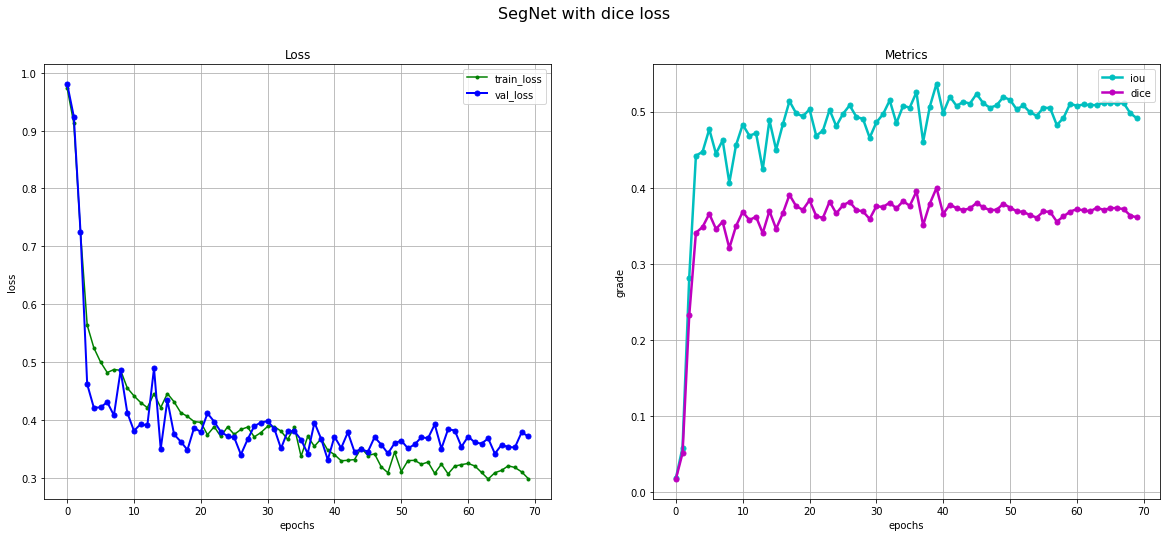

In [7]:
visualize_history(history_segnet_with_dice_loss, ['iou', 'dice'], title='SegNet with dice loss')

### Public score: 0.50024

### Private score: 0.37757

## DPN Net

epoch 152/152
tr_loss: 0.286982
val_loss: 0.462747
iou_metric: 0.532672
dice_metric: 0.414372


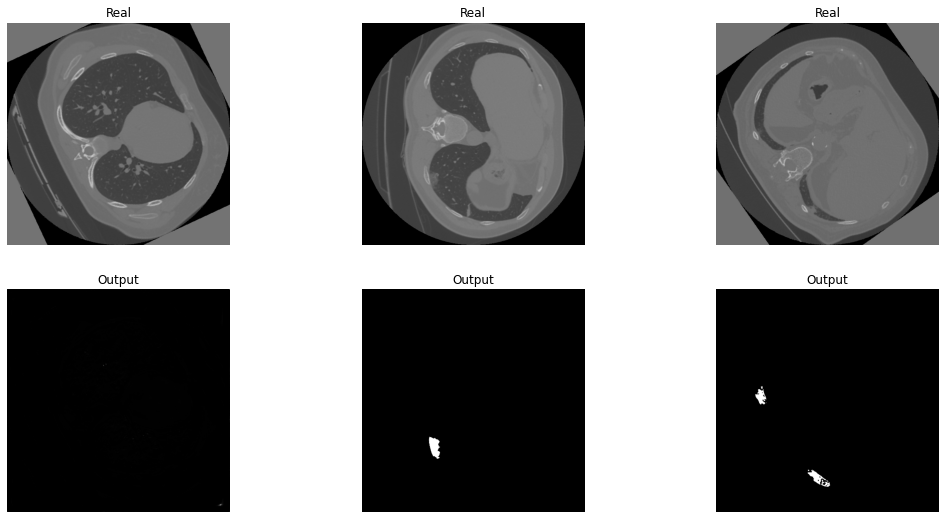

In [ ]:
epochs = 152
model = smp.UnetPlusPlus(encoder_name='dpn68b',
                         encoder_weights="imagenet+5k",
                         in_channels=1, classes=1,
                         activation="sigmoid").to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
lr_sched = torch.optim.lr_scheduler.StepLR(optim, step_size=15, gamma=0.9)

history_dpn_net_with_focal_tversky_loss = train(model, optim, lr_sched,
                                                focal_tversky_loss, epochs,
                                                train_loader, valid_loader,
                                                [iou_metric, dice_metric],
                                                CHECKPOINTS_PATH)

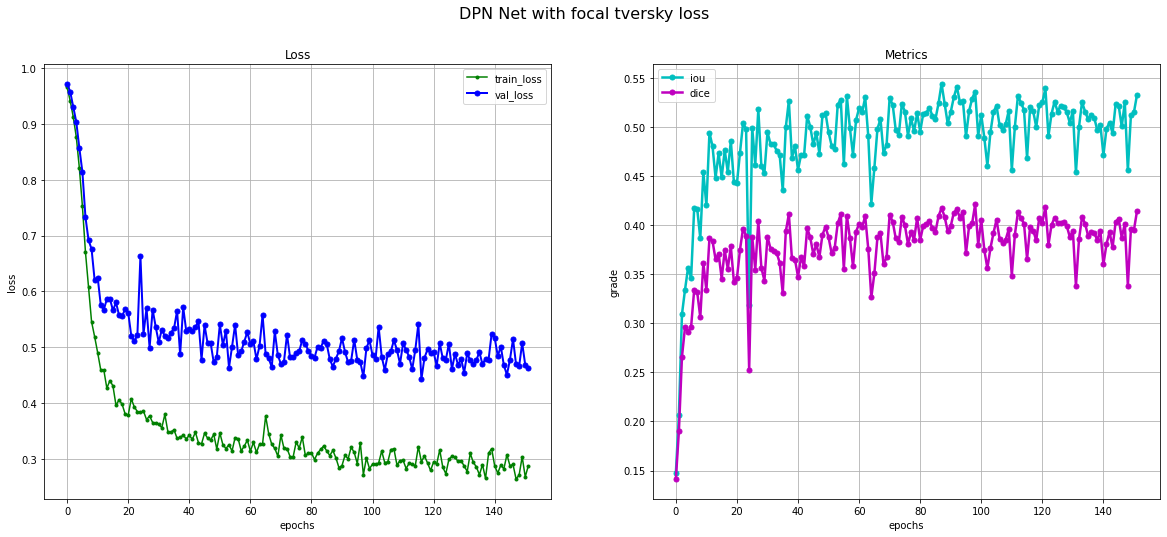

In [ ]:
visualize_history(history_dpn_net_with_focal_tversky_loss, ['iou', 'dice'], title='DPN Net with focal tversky loss')

### Public score: 0.61008

### Private score: 0.54510


## EfficientNet

epoch 152/152
tr_loss: 0.268346
val_loss: 0.303148
iou_metric: 0.662292
dice_metric: 0.477992


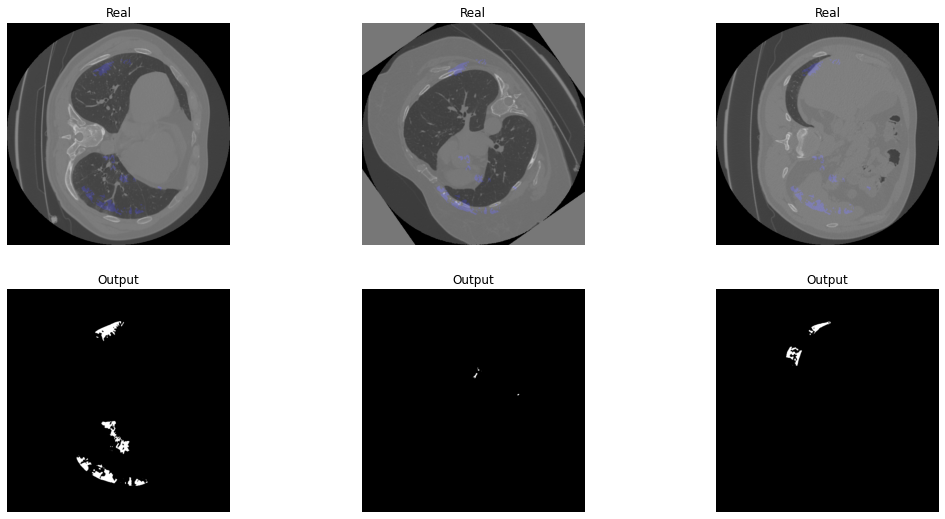

In [ ]:
epochs = 152
model = smp.UnetPlusPlus(encoder_name='efficientnet-b2',
                         encoder_weights="imagenet",
                         in_channels=1, classes=1,
                         activation="sigmoid").to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
lr_sched = torch.optim.lr_scheduler.MultiplicativeLR(optim, lambda x: 0.9825)

history_efficientnet_with_focal_tversky_loss = train(model, optim, lr_sched,
                                                     focal_tversky_loss, epochs,
                                                     train_loader, valid_loader,
                                                     [iou_metric, dice_metric],
                                                     CHECKPOINTS_PATH)

Во время обучения я решил перемешать данные для обучения и валидации и создал новые loader'ы, поэтому на графиках получился такой скачок

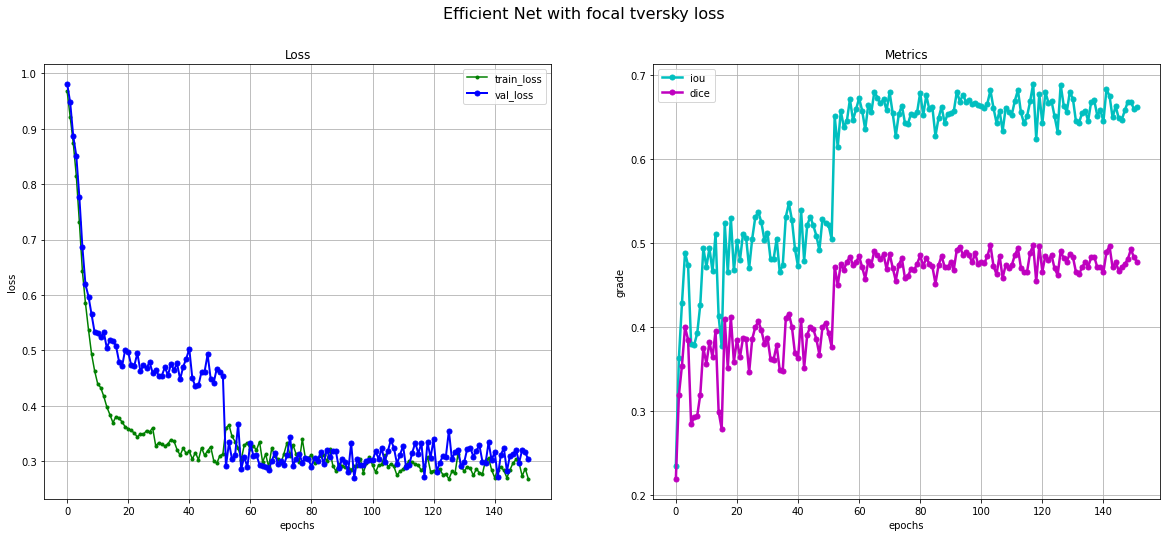

In [9]:
visualize_history(history_efficientnet_with_focal_tversky_loss, ['iou', 'dice'], title='Efficient Net with focal tversky loss')

### Public score: 0.66415

### Private score: 0.61963

# Evaluation

In [ ]:
"""
Load testing data into images and labels lists

images list consists of CT scans -  numpy arrays of shape (512, 512, n_slices)
"""


labels_predicted = []
images_testing = []
threshold = 0.9


with open(CORE_PATH + 'testing_data.json', 'r') as f:
    dict_testing = json.load(f)

for entry in tqdm(dict_testing):
    image = nib.load(os.path.join(DATA_PATH + 'images/', entry['image'][:-3])).get_fdata()
    images_testing.append(image)
    image = torch.tensor(image).transpose(1, 2).transpose(0, 1).view(-1, 1, 512, 512)
    
    tmp = []
    with torch.no_grad():
        model.eval()
        for i in range(len(image)):
            img = image[i:i+1].float().to(device)
            output = model(img)
            output = output.cpu().detach().numpy()[0][0]
            output[output >= threshold] = 1
            output[output < threshold] = 0
            tmp.append(output)

    labels_predicted.append(np.dstack(tmp))

  0%|          | 0/10 [00:00<?, ?it/s]

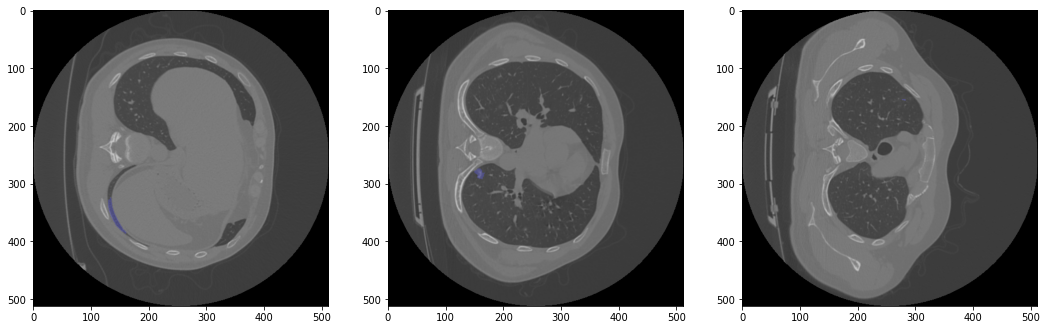

In [ ]:
# Visualize some of the predictions

patient_num = 5
slices_num = [10, 20, 30]
slices = []

slices = [blend(images_testing[patient_num][..., idx],
                labels_predicted[patient_num][..., idx],
                detach=False) for idx in slices_num]

figure = plt.figure(figsize=(18, 18))
for i, image in enumerate(slices):
    ax = figure.add_subplot(1, len(slices), i + 1)
    ax.imshow(slices[i])

In [ ]:
# Execute this cell for submission file generation 
import csv

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1):
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return [str(item) for item in run_lengths]
  

with open(f'submission.csv', "wt") as sb:
    submission_writer = csv.writer(sb, delimiter=',')
    submission_writer.writerow(["Id", "Predicted"])
    for k_i, patient_i in tqdm(zip(dict_testing, labels_predicted)):
        submission_writer.writerow([
                f"{k_i['image'][:-7]}",
                " ".join(rle_encoding(patient_i))
            ])

0it [00:00, ?it/s]